# Semantic Segmentation: UNET for Self-Driving Cars

Semantic image segmentation is the task of classifying each pixel in an image from a predefined set of classes. In the following example, different entities are classified.

In particular, our goal is to take a 2D image of size W x H x 3 and generate a W x H matrix containing the predicted class ID’s corresponding to all the pixels.

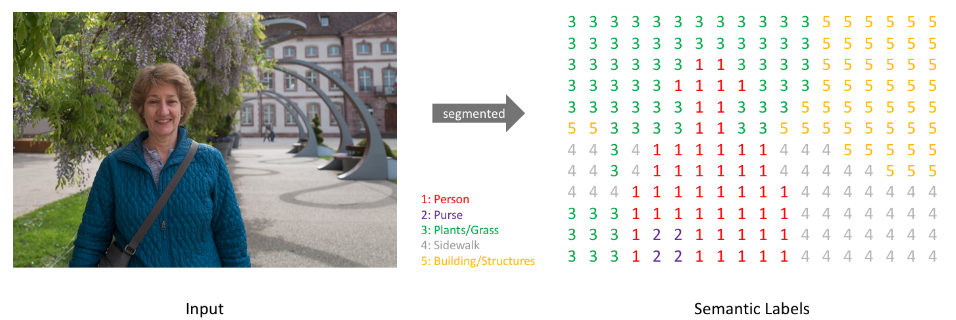

### Import Dependencies

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from glob import glob
import tensorflow
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.utils import normalize
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-02-01 17:18:45.056444: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 17:18:45.056557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 17:18:45.197534: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
tf.__version__

'2.15.0'

In [4]:
np.random.seed(2024)
SIZE = 256      # (heigth x width)

In [5]:
classes = pd.read_csv("/kaggle/input/camvid/CamVid/class_dict.csv", index_col =0)
classes.T

name,Animal,Archway,Bicyclist,Bridge,Building,Car,CartLuggagePram,Child,Column_Pole,Fence,...,SUVPickupTruck,TrafficCone,TrafficLight,Train,Tree,Truck_Bus,Tunnel,VegetationMisc,Void,Wall
r,64,192,0,0,128,64,64,192,192,64,...,64,0,0,192,128,192,64,192,0,64
g,128,0,128,128,0,0,0,128,192,64,...,128,0,64,64,128,128,0,192,0,192
b,64,128,192,64,0,128,192,64,128,128,...,192,64,64,128,0,192,64,0,0,0


During the process of data exploration we found that the reported r,g,b order is incorrect. As you can see from the following we need to switch the channels names to properly encode the MASKS. 

### Functions

In [25]:
def load_images(paths, size=SIZE, scale=None):
    img_list = []

    for image_path in paths:
        img = cv2.imread(image_path, scale)                                        # 0 to convert to grayscale (should ontain an array (n, h, w, 1) <=> (n, h, w))
        img = cv2.cvtColor((img).astype(np.uint8), cv2.COLOR_BGR2RGB)       # If you want to get the same order as in the color mapping of CAMVID, use the cv converted
        img = cv2.resize(img, (SIZE, SIZE))                                 # with default interpolation = bilinear
        img_list.append(img)
    
    return np.array(img_list)



def show_pairs(image, mask):
    
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask)
    
    plt.show()
    plt.tight_layout()


With these last 2 functions we "encode" the "revert" the mask's RGB channel into a an encoded mask. In simple terms:
- new_mask = adjust_mask(mask) -> this new_mask will have shape (256, 256, 32) where 32 is the number of channels of the image each representing one of the classes
- rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(new_mask, axis=-1), -1)) -> rgb_mask will be the reverted mask turning into shape (256, 256, 3). rgb_mask is basically the same exact thing as the mask given in input to the adjust_mask function

### Data Loading

png > jpg. the lose less info.

In [8]:
root_path = '/kaggle/input/camvid/CamVid'

train_image_paths = sorted(glob(os.path.join(root_path, 'train/*')))
train_mask_paths = sorted(glob(os.path.join(root_path, 'train_labels/*')))

val_image_paths = sorted(glob(os.path.join(root_path, 'val/*')))
val_mask_paths = sorted(glob(os.path.join(root_path, 'val_labels/*')))

test_image_paths = sorted(glob(os.path.join(root_path, 'test/*')))
test_mask_paths = sorted(glob(os.path.join(root_path, 'test_labels/*')))

In [9]:
# load data
train_images = load_images(train_image_paths, scale=1)
train_masks = load_images(train_mask_paths, scale=1)

libpng warning: iCCP: known incorrect sRGB profile


In [10]:
train_images.shape, train_masks.shape

((369, 256, 256, 3), (369, 256, 256, 3))

In [11]:
val_images = load_images(val_image_paths, scale=1)
val_masks = load_images(val_mask_paths, scale=1)

In [12]:
val_images.shape, val_masks.shape

((100, 256, 256, 3), (100, 256, 256, 3))

In [13]:
test_images = load_images(test_image_paths, scale=1)
test_masks = load_images(test_mask_paths, scale=1)

In [14]:
test_images.shape, test_masks.shape

((232, 256, 256, 3), (232, 256, 256, 3))

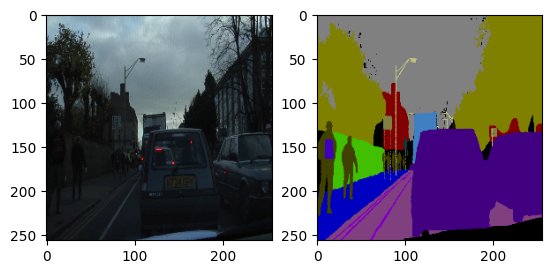

<Figure size 640x480 with 0 Axes>

In [26]:
show_pairs(train_images[1], train_masks[1])

### ENCODING

In [28]:
classes.head()

,r,g,b
name,,,
Animal,64,128,64
Archway,192,0,128
Bicyclist,0,128,192
Bridge,0,128,64
Building,128,0,0


In [29]:
# Create a class column to refer to the classes numerically

classes['Class'] = np.arange(0,  classes.shape[0])
classes.head()

,r,g,b,Class
name,,,,
Animal,64,128,64,0
Archway,192,0,128,1
Bicyclist,0,128,192,2
Bridge,0,128,64,3
Building,128,0,0,4


In [30]:
def adj_masks(class_mapping, masks):

    # Create a lookup table (a dictionary as [r, g, b] : label_class) for all RGB values
    lookup_table = class_mapping.set_index(['r', 'g', 'b'])['Class'].to_dict()

    # Extract RGB channels from masks
    r_channel = masks[:, :, :, 0]
    g_channel = masks[:, :, :, 1]
    b_channel = masks[:, :, :, 2]

    # Map RGB values to class labels using the lookup table
    class_labels = np.vectorize(lambda r, g, b: lookup_table.get((r, g, b), 30))(r_channel, g_channel, b_channel)
    
    # 30 is going be subistuted and represent the pixels not found in our rgb map from the dataframes classes (there is a spefific class call void)

    return class_labels.astype(np.uint8)
    
def back_to_rgb(class_mapping, masks):
    # Create a dictionary from the class mapping DataFrame for efficient lookup
    class_dict = class_mapping.set_index('Class')[['r', 'g', 'b']].to_dict(orient='index')

    # Convert masks to RGB-encoded masks using vectorized operations
    class_values = masks.flatten()
    rgb_encoded_masks = np.zeros((*masks.shape[:-1], 3), dtype=np.uint8)
    
    for class_val, rgb_values in class_dict.items():
        mask_indices = class_values == class_val
        rgb_encoded_masks[mask_indices.reshape(masks.shape[0], masks.shape[1], masks.shape[2]), :] = [rgb_values['r'], rgb_values['g'], rgb_values['b']]

    return rgb_encoded_masks

In [31]:
## check if the ENCODE-DECODE from rgb to class and back to rgb from class is working:

prova = adj_masks(classes, train_masks[:10])
prova = np.expand_dims(prova, axis=3)
prova = back_to_rgb(classes, prova)

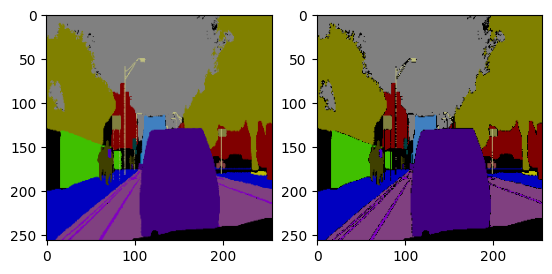

<Figure size 640x480 with 0 Axes>

In [32]:
show_pairs(train_masks[3], prova[3])

### Start encoding the data

In [33]:
train_masks_encoded = adj_masks(classes, train_masks)

train_masks_encoded = np.expand_dims(train_masks_encoded, 3)
train_masks_encoded.shape

(369, 256, 256, 1)

In [34]:
np.unique(train_masks_encoded)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31],
      dtype=uint8)

In [35]:
val_masks_encoded = adj_masks(classes, val_masks)

val_masks_encoded = np.expand_dims(val_masks_encoded, 3)
val_masks_encoded.shape

(100, 256, 256, 1)

In [36]:
np.unique(val_masks_encoded)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31], dtype=uint8)

In [37]:
test_masks_encoded = adj_masks(classes, test_masks)

test_masks_encoded = np.expand_dims(test_masks_encoded, 3)
test_masks_encoded.shape

(232, 256, 256, 1)

In [38]:
np.unique(test_masks_encoded)


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31], dtype=uint8)

In [39]:
len(np.unique(train_masks_encoded)), len(np.unique(val_masks_encoded)), len(np.unique(test_masks_encoded))

(31, 30, 30)

In [ ]:
# train masks have 1 more class that the others two do not have (class 25); also class 28 is missing in all of them
# we'll remove the observations from train_images and train_masks and redo the encoding

# also we'll remove class 28 from all of our sets

In [40]:
classes.tail(7)
# choose train rgb 

,r,g,b,Class
name,,,,
Train,192,64,128,25
Tree,128,128,0,26
Truck_Bus,192,128,192,27
Tunnel,64,0,64,28
VegetationMisc,192,192,0,29
Void,0,0,0,30
Wall,64,192,0,31


In [41]:
rgb_25 = np.array([192, 64, 128])
rgb_25

array([192,  64, 128])

In [43]:
# Create a function to remove observations within train_images and train_masks containing the class 25

def remove_class(masks, rgb, images):
    # Check for equality along the last axis to identify masks containing the rgb value
    contains_rgb = np.any(np.all(masks == rgb, axis=-1), axis=(1, 2))

    # Find the indices of masks containing the rgb value
    containing_indices = np.where(contains_rgb)[0]

    # Remove masks containing the rgb value
    return np.delete(masks, containing_indices, axis=0), np.delete(images, containing_indices, axis=0)

In [44]:
train_masks, train_images = remove_class(train_masks, rgb_25, train_images)

In [45]:
# We succesfully removed the observations from class 25

train_masks.shape, train_images.shape

((368, 256, 256, 3), (368, 256, 256, 3))

In [48]:
# Update class csv by removing unused classes

# these are the classes we have in ALL SETS (Train, test, val) -> we don't have 25 and 28
classes_in = [0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31]

condition = classes['Class'].isin(classes_in)
classes = classes[condition]
classes

,r,g,b,Class
name,,,,
Animal,64,128,64,0
Archway,192,0,128,1
Bicyclist,0,128,192,2
Bridge,0,128,64,3
Building,128,0,0,4
Car,64,0,128,5
CartLuggagePram,64,0,192,6
Child,192,128,64,7
Column_Pole,192,192,128,8


In [49]:
# Now re arrange class column

classes['Class'] = np.arange(0,  classes.shape[0])
classes.tail()

/tmp/ipykernel_5940/3687831022.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classes['Class'] = np.arange(0,  classes.shape[0])


,r,g,b,Class
name,,,,
Tree,128,128,0,25
Truck_Bus,192,128,192,26
VegetationMisc,192,192,0,27
Void,0,0,0,28
Wall,64,192,0,29


In [51]:
# Update adj mask function (now void class is 28)

def adj_masks(class_mapping, masks):

    # Create a lookup table (a dictionary as [r, g, b] : label_class) for all RGB values
    lookup_table = class_mapping.set_index(['r', 'g', 'b'])['Class'].to_dict()

    # Extract RGB channels from masks
    r_channel = masks[:, :, :, 0]
    g_channel = masks[:, :, :, 1]
    b_channel = masks[:, :, :, 2]

    # Map RGB values to class labels using the lookup table
    class_labels = np.vectorize(lambda r, g, b: lookup_table.get((r, g, b), 28))(r_channel, g_channel, b_channel)
    
    # 30 is going be subistuted and represent the pixels not found in our rgb map from the dataframes classes (there is a spefific class call void)

    return class_labels.astype(np.uint8)

In [52]:
# Redo the encoding on the masks
train_masks_encoded = adj_masks(classes, train_masks)
train_masks_encoded = np.expand_dims(train_masks_encoded, 3)


test_masks_encoded = adj_masks(classes, test_masks)
test_masks_encoded = np.expand_dims(test_masks_encoded, 3)


# Redo the encoding on the masks
val_masks_encoded = adj_masks(classes, val_masks)
val_masks_encoded = np.expand_dims(val_masks_encoded, 3)


In [53]:
np.unique(train_masks_encoded)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=uint8)

In [54]:
len(np.unique(train_masks_encoded)), len(np.unique(val_masks_encoded)), len(np.unique(test_masks_encoded))

(30, 30, 30)

In [55]:
train_masks_encoded.shape, val_masks_encoded.shape, test_masks_encoded.shape, 

((368, 256, 256, 1), (100, 256, 256, 1), (232, 256, 256, 1))

### One hot encode 

In [56]:
from tensorflow.keras.utils import to_categorical

train_masks_encoded = to_categorical(train_masks_encoded, num_classes=30) 
val_masks_encoded = to_categorical(val_masks_encoded, num_classes=30)
test_masks_encoded = to_categorical(test_masks_encoded, num_classes=30) 


In [57]:
train_masks_encoded.shape, val_masks_encoded.shape, test_masks_encoded.shape

((368, 256, 256, 30), (100, 256, 256, 30), (232, 256, 256, 30))

In [58]:
train_masks_encoded[0]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1.

### Preprocessing for modeling

Without touching out out OHE masks, we used normalization and not the dividision of every pixel by 255, obtaining pixel values between 0 and 1 in float32 format.
$$X_{normalized} = \frac{x-x_{min}}{x_{max}-x_{min}}$$

In [59]:
train_images = normalize(train_images, axis=1)

Since we are dealing with a multiclass problem, there is a high chance that, as we can see from the images and masks, there is class imbalance in terms of weights meaning that there are some classes (like the road or the walls) that have much more in-sample observations with pixels associated to them, implying that other minority classes (such as people, animals, trees..) have less training examples. By pixels we mean 1s in the OHE mask tensor. We will address this problem by using a loss function that accounts for class imbalance!

Speaking about the training procedure, we could think that a Unet-like architecture should need many training examples. However Unet was conceived for biomedical images and complex structures working extremly well also with few examples (think about mithocondria or other cells to be analyzed: it's difficult to have a big, precise dataset of such pictures).

Now do the needed Preprocessing for validation and test set.

In [60]:
val_images = normalize(val_images, axis=1)
test_images = normalize(test_images, axis=1)

In [62]:
train_images.shape, train_masks_encoded.shape

# INPUT IMAGE is an RGB image
# OUTPUT IMAGE is a 30 channel image (one hot encoded) that we 
# will revert to rgb after the prediction to compare it with the ground truth mask

((368, 256, 256, 3), (368, 256, 256, 30))

### Loss choices

Focal Loss in multiclass classification formula: (someone also uses some hybrid loss by performing a linear combination of 2 losses)
$$Focal Loss = -\alpha*((1-p)^\gamma)*log(p)$$
Parameters:
- $\alpha$ -> the same as wighting factor in balanced cross entropy
- $\gamma$ -> focusing parameter for modulating factor (1-p)

Default value:
- $\gamma = 2.0$ as mentioned in the paper
- $\alpha = 0.25$ as mentioned in the paper

paper: https://arxiv.org/pdf/1708.02002.pdf

tf: https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalFocalCrossentropy

# Define the models

In [63]:
# General
import tensorflow as tf
from tensorflow.keras import backend as K

# Network Architecture
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout, BatchNormalization, Activation, Add
from keras.optimizers import Adam

# Metrics
from keras.metrics import MeanIoU

In [64]:
# model shapes

IMG_HEIGHT = train_images.shape[1]
IMG_WIDTH  = train_images.shape[2]
IMG_CHANNELS = train_images.shape[3]

shapes = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

## Simple-Unet

In [65]:
############################################################################################################################################################################

# BLOCKS
def contraction_block(input_tensor, num_filters, doBatchNorm = True, drop_rate = None):
    x = Conv2D(num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(input_tensor)      # strides default to 1
    if doBatchNorm:
        x = BatchNormalization()(x)             # to make computations more efficient
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)
    if doBatchNorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    pooled = MaxPooling2D((2, 2))(x)            # OG paper proposed strides=2 but we leave them default to pool_size = 2
    pooled = Dropout(drop_rate)(pooled)
    return x, pooled



def expansive_block(copy, input_tensor, num_filters, doBatchNorm = True, drop_rate = None):  
    # Conv2dtranspose =! upsampling (both the concept and the keras layer). both increase dim of arrays.
    # upsampling2d is the opposite of pooling repeating rows and columns of input.
    # Conv2dtranspose performs upsampling and then convolution. 
    x = Conv2DTranspose(num_filters, kernel_size = (3, 3), strides = (2, 2), padding='same')(input_tensor)       

    # Concatenation: crop the copy from the specular contraction block and concatenate it to the
    # current respective decoder layer of the expansive path
    x = concatenate([x, copy])

    # add simple 2D convolutions
    x = Conv2D(num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)      # strides default to 1
    if doBatchNorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)
    if doBatchNorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(drop_rate)(x)
    return x


# will be useful also for autoencoder
def convolution_block(input_tensor, num_filters, drop_rate = None, doBatchNorm = True):
    x = Conv2D(num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(input_tensor)
    if doBatchNorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)
    if doBatchNorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(drop_rate)(x)
    return x


# UNET
def Unet(input_size, filters = 16, n_classes = None, activation='sigmoid'):
    input_layer = Input(input_size)

    copy1, p1 = contraction_block(input_tensor=input_layer, num_filters = filters*1, drop_rate=0.1, doBatchNorm=True)
    copy2, p2 = contraction_block(input_tensor=p1, num_filters = filters*2, drop_rate=0.1, doBatchNorm=True)
    copy3, p3 = contraction_block(input_tensor=p2, num_filters = filters*4, drop_rate=0.2, doBatchNorm=True)
    copy4, p4 = contraction_block(input_tensor=p3, num_filters = filters*8, drop_rate=0.2, doBatchNorm=True)

    x5 = convolution_block(input_tensor=p4, num_filters=filters*16, drop_rate = 0.2, doBatchNorm=True)

    p6 = expansive_block(copy=copy4, input_tensor=x5, num_filters = filters*8, drop_rate = 0.2, doBatchNorm=True)
    p7 = expansive_block(copy=copy3, input_tensor=p6, num_filters = filters*4, drop_rate = 0.2, doBatchNorm=True)
    p8 = expansive_block(copy=copy2, input_tensor=p7, num_filters = filters*2, drop_rate = 0.1, doBatchNorm=True)
    p9 = expansive_block(copy=copy1, input_tensor=p8, num_filters = filters*1, drop_rate = 0.1, doBatchNorm=True)

    # num_classes should be 3 if working with OG images and masks
    output = Conv2D(filters=n_classes, kernel_size=(1, 1), activation=activation)(p9)
    model = Model(inputs=[input_layer], outputs=[output], name='Unet')
    return model

In [66]:
model = Unet(input_size=shapes, filters = 16, n_classes = 30, activation='softmax')
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [67]:
model.summary()

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 16)         0         ['batch_normalization[0][0]

In [68]:
history = model.fit(train_images, train_masks_encoded,                                # train_images, train_masks_encoded,  
                    verbose=1,
                    batch_size = 8,
                    validation_data = (val_images, val_masks_encoded),
                    epochs=200)

Epoch 1/200


2024-02-01 17:36:51.411514: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inUnet/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1706809015.752497    5983 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


46/46 [==============================] - 26s 197ms/step - loss: 2.8662 - accuracy: 0.2574 - val_loss: 4.0529 - val_accuracy: 0.1053
Epoch 2/200
46/46 [==============================] - 5s 118ms/step - loss: 2.0183 - accuracy: 0.6276 - val_loss: 3.4763 - val_accuracy: 0.2937
Epoch 3/200
46/46 [==============================] - 5s 119ms/step - loss: 1.5264 - accuracy: 0.6851 - val_loss: 2.8917 - val_accuracy: 0.3388
Epoch 4/200
46/46 [==============================] - 5s 118ms/step - loss: 1.2669 - accuracy: 0.7166 - val_loss: 3.0026 - val_accuracy: 0.3173
Epoch 5/200
46/46 [==============================] - 5s 119ms/step - loss: 1.1187 - accuracy: 0.7445 - val_loss: 3.3412 - val_accuracy: 0.3026
Epoch 6/200
46/46 [==============================] - 5s 119ms/step - loss: 1.0020 - accuracy: 0.7661 - val_loss: 3.3681 - val_accuracy: 0.3267
Epoch 7/200
46/46 [==============================] - 5s 119ms/step - loss: 0.9398 - accuracy: 0.7731 - val_loss: 4.1153 - val_accuracy: 0.2856
Epoch 8/20

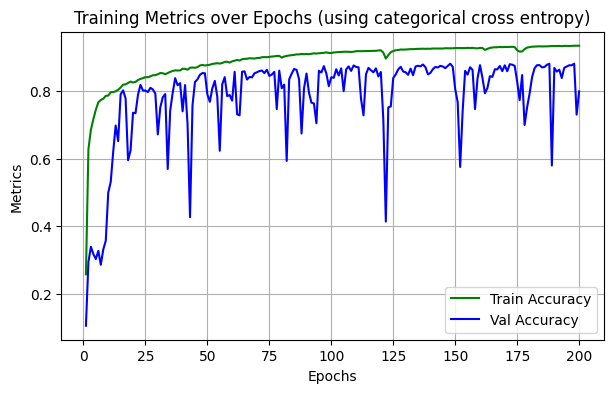

In [69]:
train_acc_history = history.history['accuracy']
val_acc_history = history.history['val_accuracy']


epochs = np.arange(1, len(val_acc_history)+1)

plt.figure(figsize=(7, 4))


plt.plot(epochs, train_acc_history, label='Train Accuracy', color='green')
plt.plot(epochs, val_acc_history, label='Val Accuracy', color='blue')


plt.title('Training Metrics over Epochs (using categorical cross entropy)')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()

plt.grid(True)
plt.show()

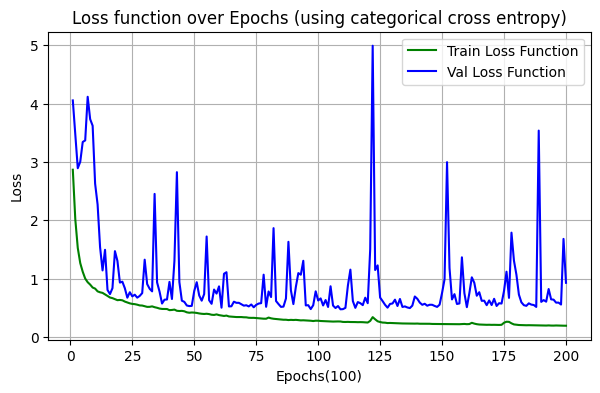

In [70]:
train_loss_history = history.history['loss']
val_loss_history = history.history['val_loss']


plt.figure(figsize=(7, 4))

plt.plot(epochs, train_loss_history, label='Train Loss Function', color='green')
plt.plot(epochs, val_loss_history, label='Val Loss Function', color='blue')


plt.title('Loss function over Epochs (using categorical cross entropy)')
plt.xlabel('Epochs(100)')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()

In [71]:
# PREDICT AND CONVERT BACK TO RGB

y_pred=model.predict(test_images)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax = np.expand_dims(y_pred_argmax, axis=3)

8/8 [==============================] - 4s 53ms/step


In [72]:
y_pred_rgb = back_to_rgb(classes, y_pred_argmax)

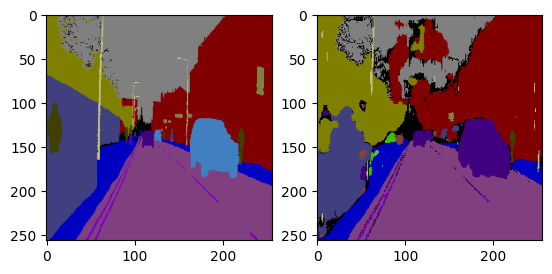

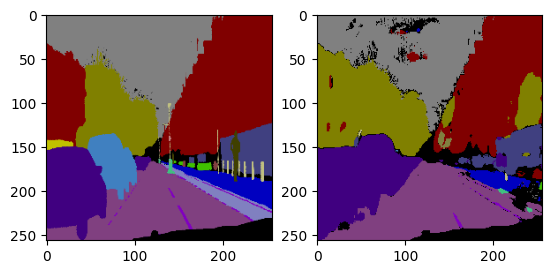

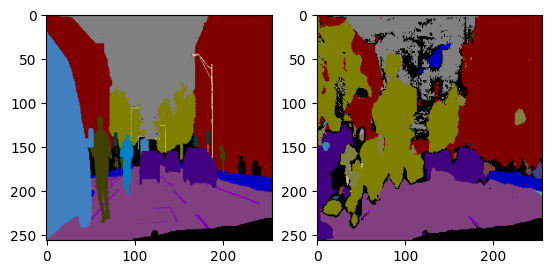

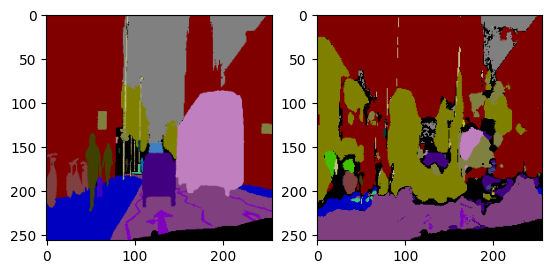

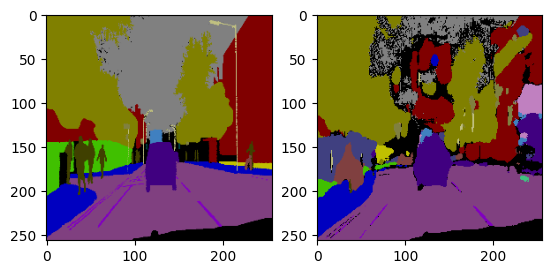

<Figure size 640x480 with 0 Axes>

In [101]:
# 200 epochs, categorical_crossentropy, softmax

rand = np.random.randint(1, y_pred_argmax.shape[0], 5)

for i in rand:
    show_pairs(test_masks[i], y_pred_rgb[i]), 


## Residual Unet with categorical focal cross_entropy

In [80]:
# Residual block: https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf (fig 4)
# there are 2 variants (2. is the one proposed in OG paper of ResNet)
# 1. conv - BN - Activation - conv - BN - Activation - shortcut  - BN - shortcut+BN
# 2. conv - BN - Activation - conv - BN - shortcut  - BN - addition() - Activation

def residual_contraction_block(input_tensor, num_filters, doBatchNorm = True): 
    x = Conv2D(num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(input_tensor)       # default kernel initializer to "glorot_uniform"
    if doBatchNorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)
    if doBatchNorm:
        x = BatchNormalization()(x)
    # x = Activation('relu')(x)    #Activation before addition with residual

    # 1x1 convolution on input image
    residual = Conv2D(num_filters, kernel_size=(1, 1), kernel_initializer='he_normal', padding='same')(input_tensor)
    if doBatchNorm:
        residual = BatchNormalization()(residual)
    
    # sum convolution block with residual and perform 2x2 max pooling
    res_x = Add()([residual, x])
    res_x = Activation('relu')(res_x)       # act f in the end like the OG paper proposes
    # pooled = MaxPooling2D((2, 2))(res_x)
    # pooled = Dropout(drop_rate)(pooled)
    # return pooled
    return res_x


def ResUnet(input_size, filters = 16, n_classes = None, activation='sigmoid'):
    input_layer = Input(input_size)

    # downsample
    x1 = residual_contraction_block(input_tensor=input_layer, num_filters = filters*1, doBatchNorm = True)    
    p1 = MaxPooling2D((2, 2))(x1)
    p1 = Dropout(rate=0.1)(p1)

    x2 = residual_contraction_block(input_tensor=p1, num_filters = filters*2, doBatchNorm = True)    
    p2 = MaxPooling2D((2, 2))(x2)
    p2 = Dropout(rate=0.1)(p2)

    x3 = residual_contraction_block(input_tensor=p2, num_filters = filters*4, doBatchNorm = True)    
    p3 = MaxPooling2D((2, 2))(x3)
    p3 = Dropout(rate=0.2)(p3)

    x4 = residual_contraction_block(input_tensor=p3, num_filters = filters*8, doBatchNorm = True)    
    p4 = MaxPooling2D((2, 2))(x4)
    p4 = Dropout(rate=0.2)(p4)

    # intermediate
    x5 = residual_contraction_block(input_tensor=p4, num_filters = filters*16, doBatchNorm = True)
    x5 = Dropout(rate=0.2)(x5)

    # upsample
    x6 = Conv2DTranspose(filters = filters*8, kernel_size = (3, 3), strides = (2, 2), padding='same')(x5)
    x7 = concatenate([x6, x4])
    x8 = residual_contraction_block(input_tensor=x7, num_filters = filters*8, doBatchNorm = True)
    x8 = Dropout(rate=0.2)(x8)

    x9 = Conv2DTranspose(filters = filters*4, kernel_size = (3, 3), strides = (2, 2), padding='same')(x8)
    x10 = concatenate([x9, x3])
    x11 = residual_contraction_block(input_tensor=x10, num_filters = filters*4, doBatchNorm = True)
    x11 = Dropout(rate=0.2)(x11)

    x12 = Conv2DTranspose(filters = filters*2, kernel_size = (3, 3), strides = (2, 2), padding='same')(x11)
    x13 = concatenate([x12, x2])
    x14 = residual_contraction_block(input_tensor=x13, num_filters = filters*2, doBatchNorm = True)
    x14 = Dropout(rate=0.1)(x14)

    x15 = Conv2DTranspose(filters = filters*1, kernel_size = (3, 3), strides = (2, 2), padding='same')(x14)
    x16 = concatenate([x15, x1])
    x17 = residual_contraction_block(input_tensor=x16, num_filters = filters*1, doBatchNorm = True)
    x17 = Dropout(rate=0.1)(x17)

    output = Conv2D(filters=n_classes, kernel_size=(1, 1), activation=activation)(x17)
    model = Model(inputs=[input_layer], outputs=[output], name='ResUnet')
    return model

In [81]:
res_Unet = ResUnet(input_size=shapes, filters = 16, n_classes = 30, activation='softmax')

res_Unet.compile(optimizer='Adam',
                loss='categorical_focal_crossentropy',
                metrics=['accuracy']
                )

In [82]:
res_Unet.summary()

Model: "ResUnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 16)         448       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 256, 256, 16)         64        ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_18 (Activation)  (None, 256, 256, 16)         0         ['batch_normalization_18

In [87]:
history_res = res_Unet.fit(train_images, train_masks_encoded,                               
                    verbose=1,
                    batch_size = 16,
                    validation_data = (test_images, test_masks_encoded),
                    epochs=250)

Epoch 1/250


2024-02-01 18:09:38.322468: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inResUnet/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


23/23 [==============================] - 36s 625ms/step - loss: 0.6769 - accuracy: 0.1834 - val_loss: 3.1744 - val_accuracy: 0.1638
Epoch 2/250
23/23 [==============================] - 7s 323ms/step - loss: 0.4567 - accuracy: 0.5276 - val_loss: 1.2076 - val_accuracy: 0.1667
Epoch 3/250
23/23 [==============================] - 7s 328ms/step - loss: 0.3416 - accuracy: 0.6129 - val_loss: 0.6787 - val_accuracy: 0.2506
Epoch 4/250
23/23 [==============================] - 7s 328ms/step - loss: 0.2666 - accuracy: 0.7000 - val_loss: 0.6011 - val_accuracy: 0.3478
Epoch 5/250
23/23 [==============================] - 7s 325ms/step - loss: 0.2257 - accuracy: 0.7358 - val_loss: 0.6461 - val_accuracy: 0.3122
Epoch 6/250
23/23 [==============================] - 7s 329ms/step - loss: 0.2040 - accuracy: 0.7462 - val_loss: 0.5785 - val_accuracy: 0.3676
Epoch 7/250
23/23 [==============================] - 7s 327ms/step - loss: 0.1852 - accuracy: 0.7558 - val_loss: 0.6783 - val_accuracy: 0.3084
Epoch 8/25

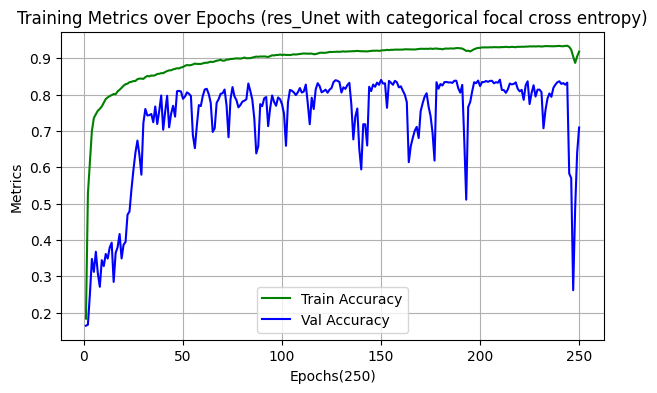

In [88]:
train_acc_history_res = history_res.history['accuracy']
val_acc_history_res = history_res.history['val_accuracy']


epochs = np.arange(1, len(val_acc_history_res)+1)

plt.figure(figsize=(7, 4))


plt.plot(epochs, train_acc_history_res, label='Train Accuracy', color='green')
plt.plot(epochs, val_acc_history_res, label='Val Accuracy', color='blue')


plt.title('Training Metrics over Epochs (res_Unet with categorical focal cross entropy)')
plt.xlabel('Epochs(250)')
plt.ylabel('Metrics')
plt.legend()

plt.grid(True)
plt.show()

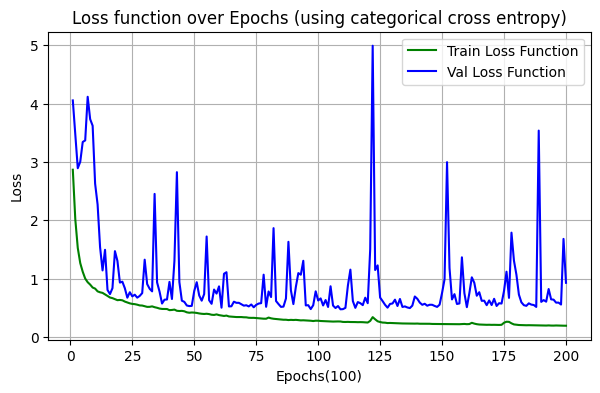

In [70]:
train_loss_history_res = history.history['loss']
val_loss_history_res = history.history['val_loss']


plt.figure(figsize=(7, 4))

plt.plot(epochs, train_loss_history_res, label='Train Loss Function', color='green')
plt.plot(epochs, val_loss_history_res, label='Val Loss Function', color='blue')


plt.title('Loss function over Epochs (res_Unet with categorical focal cross entropy)')
plt.xlabel('Epochs(250)')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()

In [92]:
# PREDICT AND CONVERT BACK TO RGB

y_pred_Res=model.predict(val_images)
y_pred_argmax_Res=np.argmax(y_pred_Res, axis=3)
y_pred_argmax_Res = np.expand_dims(y_pred_argmax_Res, axis=3)

4/4 [==============================] - 0s 60ms/step


In [93]:
y_pred_rgb_Res = back_to_rgb(classes, y_pred_argmax_Res)

In [96]:
y_pred_argmax_Res.shape[0]

(100, 256, 256, 1)

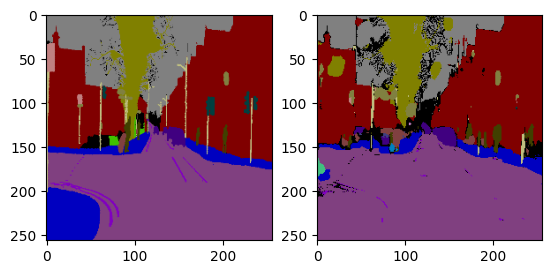

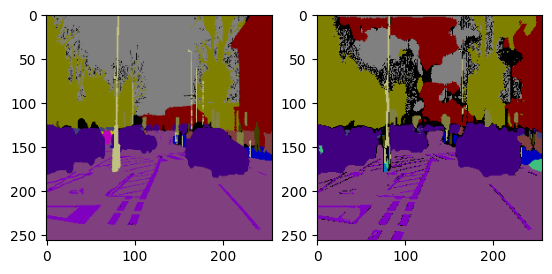

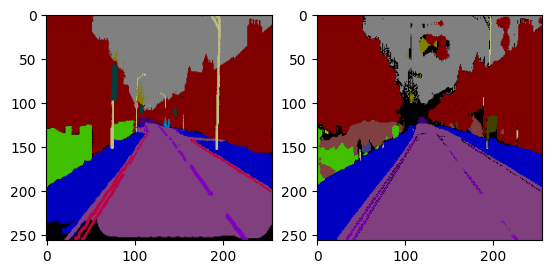

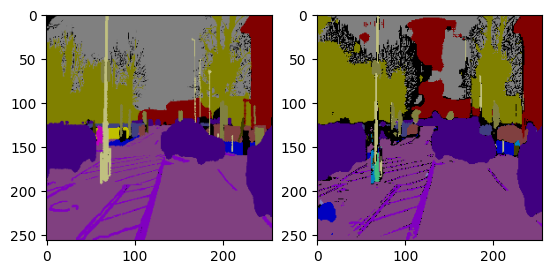

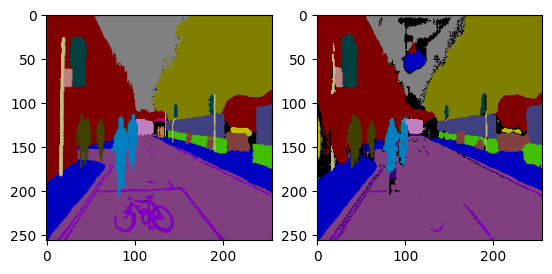

<Figure size 640x480 with 0 Axes>

In [100]:
# 200 epochs, categorical_crossentropy, softmax

rand = np.random.randint(1, y_pred_argmax_Res.shape[0], 5)

for i in rand:
    show_pairs(val_masks[i], y_pred_rgb_Res[i]), 


## Unet with pre-trained weights using Autoencoder

By leveraging the utility of an autoencoder - which as the name suggest is trying to auto-predict the image itself by downsampling and reconstructing the image - we will deploy the 'pre-trained' weights extracted from encoder part of the autoencoder in our Unet architecture. 

Basically, what we are doing is transfer learning using weights (feature maps) that were obtained by a model trained by us : we will transfer these feature maps as initial weights for the encoder of our Unet.